# **Appointment Duration**

**Aim: Make an approximation of appointment time by ICB and staff type that we can use in discrete event simulation?**
- Find all binned appointments by area
- Fit a probability distribution function
- Export to Yaml file

## Library imports

In [12]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
import os
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    os.chdir('..')

import yaml
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# project imports from src
from src.schemas import DataCatalog
import src.constants as const
from src.various_methods import PlotCounter

# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

## Initial Set-up

In [13]:
## Constants
GP_APPOINTMENTS_CATALOG_NAME:str = 'Appointments in General Practice, August 2024'
OUTPUT_YAML_FILE = "outputs/assumptions/appointment_duration.yaml"
AGE_BIN_EDGES = [1, 6, 11, 16, 21, 31, 60]
NOTEBOOK_ALIAS = "Appointment_duration"

# Load data catalog
data_catalog = DataCatalog.load_from_yaml("data_catalog.yaml")

# Initialising the plot counter (Keeps track of plot numbers)
plot_counter = PlotCounter(name=NOTEBOOK_ALIAS) 

# Set up output directories for storing plots/outputs
for i in ['outputs/assumptions', 'outputs/plots', 'outputs/tables']:
    if not os.path.exists(i):
        os.makedirs(i)

## 1. Loading the Appointments Dataframe

In [14]:
appointments_catalog_entry = data_catalog.get_catalog_entry_by_name(GP_APPOINTMENTS_CATALOG_NAME)
appointments_df = appointments_catalog_entry.load()
html_appts =  appointments_df.head(10).to_html()

## 2. Data Cleaning
- Remove unknown appointments
- Convert date columns
- Remove unrequired columns

In [15]:
appointments_df = (
    appointments_df # select only the columns we need, and remove unknown
    .loc[(appointments_df['SUB_ICB_LOCATION_CODE'].isin(const.SUB_ICB_CODES.keys())) & (appointments_df['ACTUAL_DURATION'] != "Unknown / Data Quality")]
    .assign(
        Alliance=appointments_df['SUB_ICB_LOCATION_CODE'].map(
            const.SUB_ICB_CODES), # add the alliance column
        Date=pd.to_datetime(appointments_df['Appointment_Date'], format='%d%b%Y')) # convert the date column to datetime
        # drop the columns we don't need
    .drop(columns=['SUB_ICB_LOCATION_CODE', 'SUB_ICB_LOCATION_ONS_CODE', 'SUB_ICB_LOCATION_NAME', 'ICB_ONS_CODE', 'REGION_ONS_CODE', 'Appointment_Date']))
appointments_df.head()

,ACTUAL_DURATION,COUNT_OF_APPOINTMENTS,Alliance,Date
267218,6-10 Minutes,1713,Ipswich & East Suffolk,2022-03-01
267219,31-60 Minutes,509,Ipswich & East Suffolk,2022-03-01
267220,21-30 Minutes,850,Ipswich & East Suffolk,2022-03-01
267221,16-20 Minutes,816,Ipswich & East Suffolk,2022-03-01
267222,11-15 Minutes,1314,Ipswich & East Suffolk,2022-03-01


## 3. Summary statistics

- Group by Alliance and FY
- Create left bin edges

In [16]:
appointments_binned_df = (appointments_df
                          .groupby(['Alliance', pd.Grouper(key='Date',freq='BA-MAR',label='right'),'ACTUAL_DURATION'])
                          .sum()
                          .reset_index()
                          .rename(columns={'Date':'financial_year'}).replace({"1-5":"01-05","6-10":"06-10"})
                          .assign(financial_year=lambda df: df['financial_year'].dt.year-1,
                                  left_bin=lambda x: x.ACTUAL_DURATION.map(lambda x: int(x.split("-")[0]))))

appointments_binned_df.head()

,Alliance,financial_year,ACTUAL_DURATION,COUNT_OF_APPOINTMENTS,left_bin
0,Ipswich & East Suffolk,2021,1-5 Minutes,37068,1
1,Ipswich & East Suffolk,2021,11-15 Minutes,28775,11
2,Ipswich & East Suffolk,2021,16-20 Minutes,18615,16
3,Ipswich & East Suffolk,2021,21-30 Minutes,18472,21
4,Ipswich & East Suffolk,2021,31-60 Minutes,11553,31


## 4. Convert to dictionaries & create continuous data
- Create empty dictionaries to be populated
- Pivot the data for easier conversion
- Populate the dictionaries with
    - Binned data
    - Continuous (Linear interpolation between bin edges)


In [17]:
# create empty dicts in dicts to store the binned and continuous data
binned_dict = {k: {k2: None for k2 in range(2021,2024)} for k in appointments_binned_df.Alliance.unique()}
cont_dict = {k: {k2: None for k2 in range(2021,2024)} for k in appointments_binned_df.Alliance.unique()}

# pivot the binned data
pivot_bins_df = (appointments_binned_df
                 .groupby(['Alliance','financial_year','left_bin']).sum() # sum the counts
                 .reset_index() # reset the index
                 .drop(columns=['ACTUAL_DURATION']) # drop the duration column
                 .sort_values(by=['Alliance','financial_year','left_bin']) # sort the values
                 .pivot(index=['Alliance','financial_year'],columns='left_bin',values='COUNT_OF_APPOINTMENTS')
                 .reset_index() # reset the index 
                 .fillna(0) # fill the NaNs with 0 (there are none)
                 .set_index(['Alliance','financial_year']) # set the index
                 )

# iterate through the pivot table and create the binned and continuous data
for index, row in pivot_bins_df.iterrows():
    # get the bin sums as np array
    bin_sums = row.to_numpy()
    # add to dictionary in correct place
    binned_dict[index[0]][index[1]] = bin_sums
    # create the continuous array (initially empty)
    for binned_index, bin_count in enumerate(bin_sums):
        # create the datapoints in bin
        cont_array = np.linspace(start=AGE_BIN_EDGES[binned_index], stop=AGE_BIN_EDGES[binned_index+1], num=bin_count) 
        # if it is the first, instantiate the main array
        if binned_index == 0:
            cont_array_all = cont_array
        else:
            cont_array_all = np.append(cont_array_all, cont_array)
    cont_dict[index[0]][index[1]] = cont_array_all

## 5. Plotting
### 5.1. Histograms with provided bins

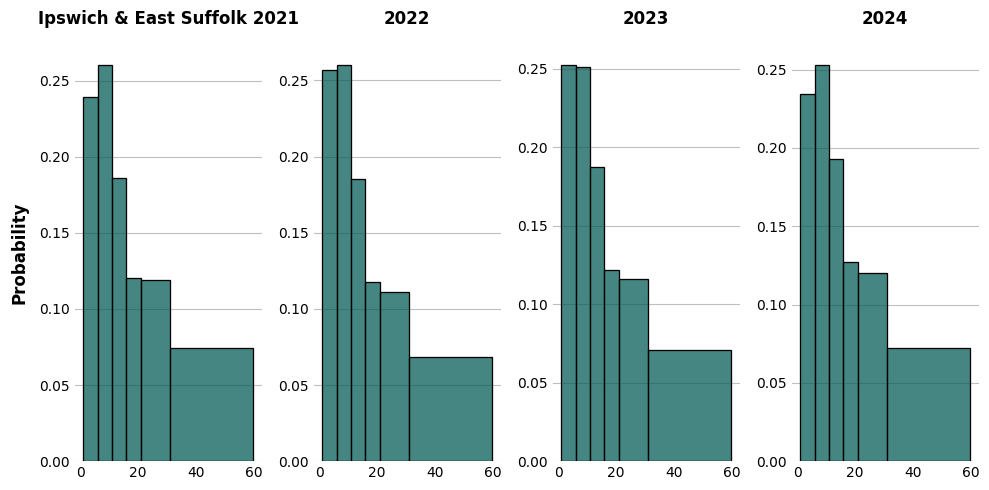

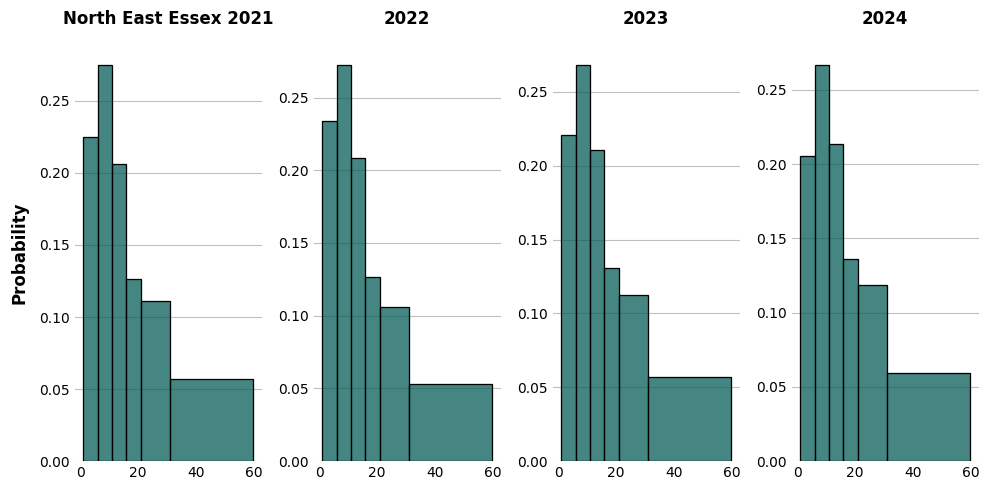

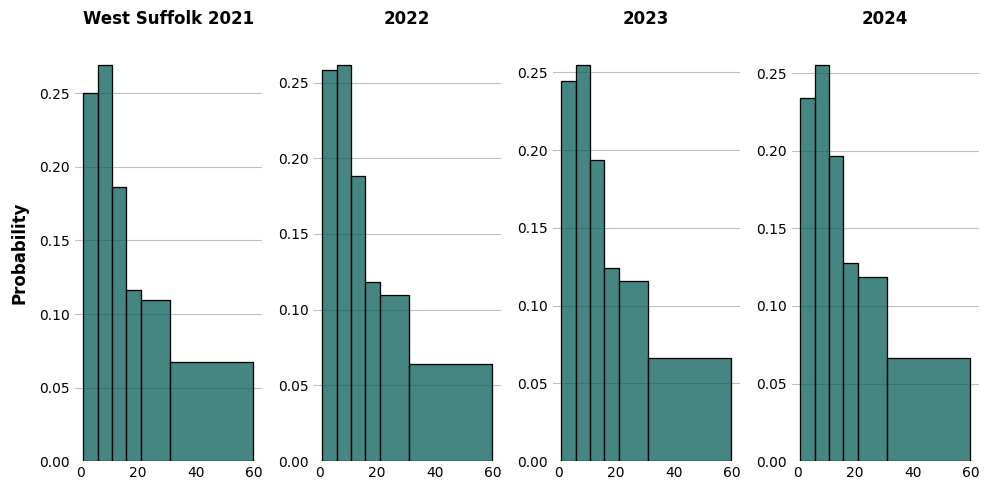

In [18]:
for alliance, dataset in cont_dict.items():
    fig, axes = plt.subplots(1,4,figsize=(10,5))
    ax_index = 0
    for year, array in dataset.items():
        ax = sns.histplot(array, kde=False, bins=AGE_BIN_EDGES, stat='probability', ax=axes[ax_index])
        if ax_index == 0:
            ax.set_title(f"{alliance} {year}")
            ax.set_ylabel("Probability")
        else:
            ax.set_title(f"{year}")
            ax.set_ylabel("")
        ax_index += 1
    plt.tight_layout()
    plt.savefig(f"{plot_counter.plot_name}.png", dpi=300)

### 5.2. Distribution examples        

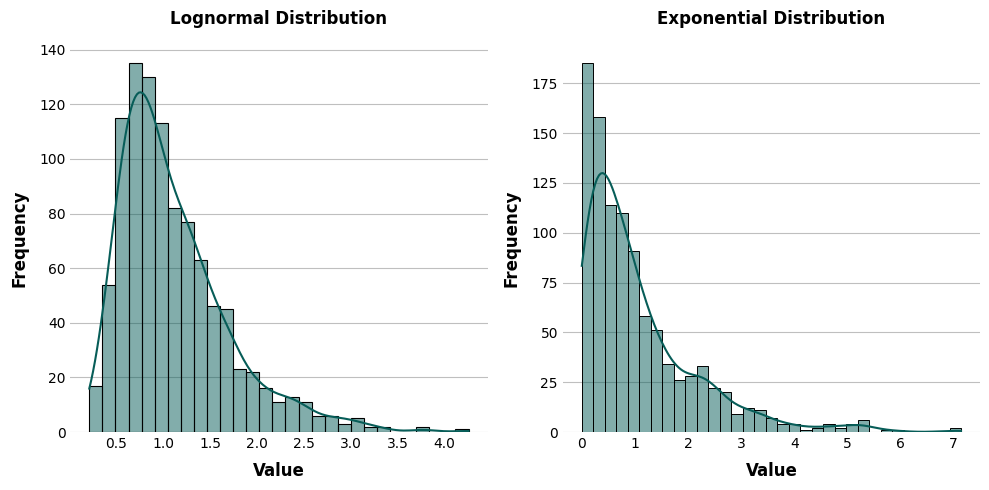

In [19]:
lognorm_example =stats.lognorm.rvs(0.5, size=1000, scale=1)
exponential_example = stats.expon.rvs(size=1000, scale=1)

# plot two example distributions
fig, axes = plt.subplots(1,2,figsize=(10,5))
# Plot the lognormal distribution
sns.histplot(lognorm_example, kde=True, bins='auto', ax=axes[0])
axes[0].set_title('Lognormal Distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Plot the exponential distribution
sns.histplot(exponential_example, kde=True, bins='auto', ax=axes[1])
axes[1].set_title('Exponential Distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(f"{plot_counter.plot_name}.png", dpi=300)

### 5.3. Fit distributions
- Exponential
- Lognormal

In [20]:
# loop over binned_dict and fit distributions
fitted_distributions = {}
for alliance, years in cont_dict.items():
    if not fitted_distributions.get(alliance, None):
        fitted_distributions[alliance] = {}# add dict entry
    for year, array in years.items():
        if array is not None:
            # Fit an exponential distribution to the data using MLE
            expon_fit_params = list(float(i) for i in stats.expon.fit(array))
            lognorm_fit_params = list(float (i) for i in stats.lognorm.fit(array))
            fitted_distributions[alliance][year] = {"lognorm":lognorm_fit_params, "expon":expon_fit_params}

### 5.4. Plot 'Theoretical' distributions

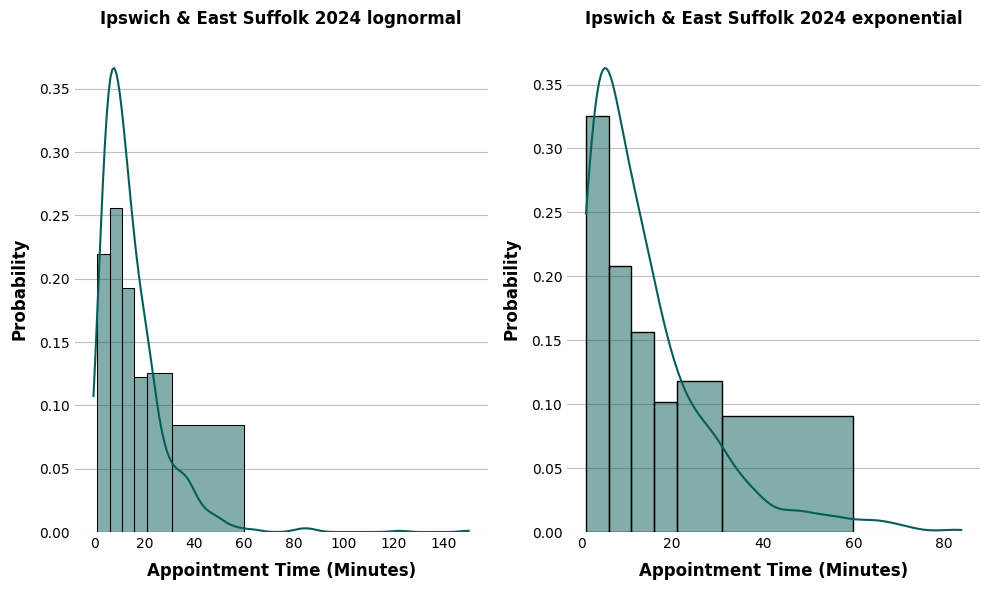

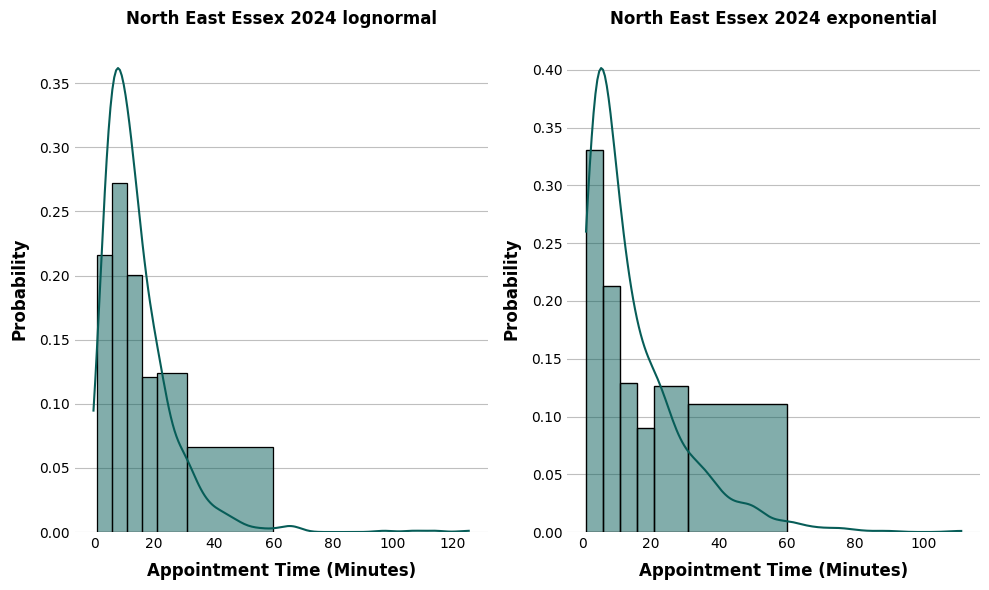

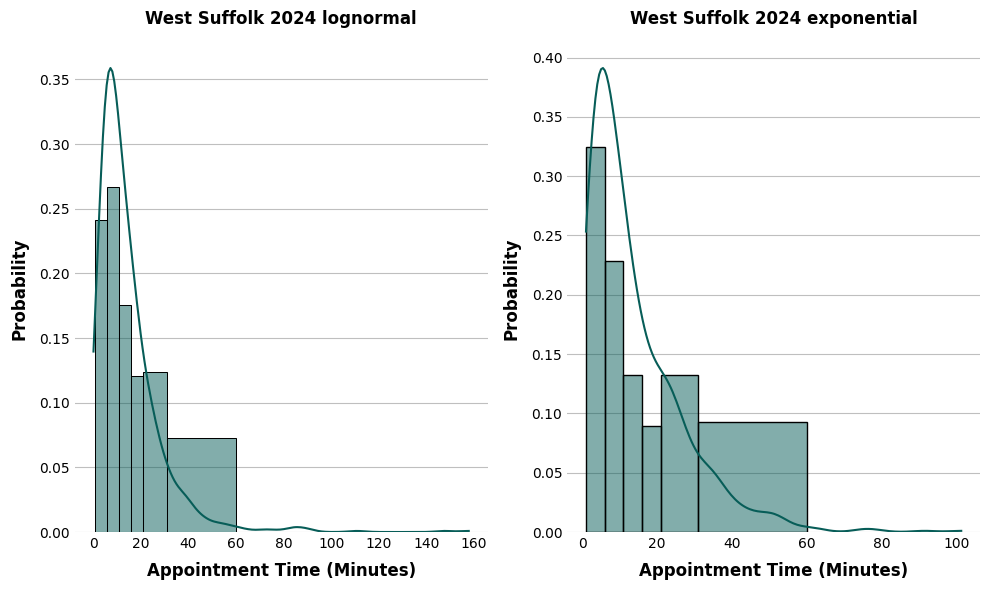

In [21]:
for alliance, years in fitted_distributions.items():
    for year, params in years.items():
        if year==2024:
            lognorm_samples = stats.lognorm.rvs(*params['lognorm'], size=1000)
            expon_samples = stats.expon.rvs(*params['expon'], size=1000)
            fig, axes = plt.subplots(1,2,figsize=(10,6))
            ax = sns.histplot(lognorm_samples, kde=True, bins=AGE_BIN_EDGES, stat='probability', ax=axes[0])
            ax.set_title(f"{alliance} {year} lognormal")
            ax.set_ylabel("Probability")
            ax.set_xlabel("Appointment Time (Minutes)")
            ax = sns.histplot(expon_samples, kde=True, bins=AGE_BIN_EDGES, stat='probability', ax=axes[1])
            ax.set_xlabel("Appointment Time (Minutes)")
            ax.set_title(f"{alliance} {year} exponential")
            ax.set_ylabel("Probability")
    plt.tight_layout()
    plt.savefig(f"{plot_counter.plot_name}.png", dpi=300)        

## 6. Export to YAML
#### Using 2024 data

In [22]:
reverse_sub_icb_codes = {v:k for k,v in const.SUB_ICB_CODES.items()}
distributions_2024 = {reverse_sub_icb_codes[k]: {dist: params for dist, params in v[2024].items()} for k,v in fitted_distributions.items()}

# output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(distributions_2024, yaml_file)